# Classificação binária de imagens de ressonâncias magnética em tumores cerebrais

A arquitetura da Rede Neural Convolucional presente nesse repositório é baseada no artigo Multi-Classification of Brain Tumor Images Using Deep Neural Network. O artigo proposto pela equipe H. H. Sultan (2019) desenvolve um modelo de aprendizado profundo, responsável por classificar diferentes tipos de tumores cerebrais, representados como meningioma, glioma e tumor hipofisário, porém, nesse modelo será aplicado classificação binária de acordo com a proposta de arquitetura desenvolvida pela equipe.

- Bibliografia:
   Link:





## Bibliotecas



In [11]:
import torch
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import cv2                 as cv 
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import seaborn             as sns

from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split

print("Versão:",torch.__version__)

Versão: 1.10.0+cu111


## Importação de arquivos

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Cria variáveis responsáveis por receber nosso path de arquivos de dados
path_teste = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Testing'
path_treino = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Treinimg'

## Tratamento e modelagem de dados

In [4]:
#Aplicamos a semente geradora
#torch.manual_seed(123)

Ao aplicar uma semente geradora mínima, podemos gerar números aleatórios em nosso processo de aprendizado profundo, de modo que ao inserir uma semente dentro do parâmetro, poderemos obter o mesmo conjunto de números aleatórios novamente.

In [5]:
'''
Após recebermos nossos caminhos, transformamos nossos conjuntos de 
dados em tensores, mas fazendo alterações de imagens.
'''
transform_train = transforms.Compose(
    [
        transforms.Resize([128,128]),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomAffine(degrees=45, translate=(0, 0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize([128,128]),
        transforms.ToTensor()
    ]
)

A utilização de redimensionamento e transformação de imagem podemos fazer com que as imagens possem filtro ou sejam passíveis de mudança, para que o conjunto de treinamento possua características mais aplicáveis ao ser treinado e validado.

In [6]:
#Aplicamos nossos tensores em tipos de dados dataset
train_dataset = datasets.ImageFolder(path_treino, transform=transform_train)
test_dataset = datasets.ImageFolder(path_teste, transform=transform_test)

Teremos como resposta logo abaixo, a listagem dos parâmetros que nossas bases de treino e teste possuem, ou seja, tipos de transformações feitas nas imagens, local do url e número de data points.

In [7]:
print(train_dataset, "\n"*2, test_dataset)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Treinimg
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 

 Dataset ImageFolder
    Number of datapoints: 394
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Testing
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [8]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
  count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
  for i in dataset_obj:
    y_labels = i[1]
    y_labels = idx2class[y_labels]
    count_dict[y_labels] += 1
  return count_dict

In [9]:
print("Distribuição de classes:\n")
get_class_distribution(train_dataset)

Distribuição de classes:



{'no_tumor': 395, 'yes_tumor': 2475}

Text(0.5, 1.0, 'Distribuição de Imagens de ressonâncias magnéticas')

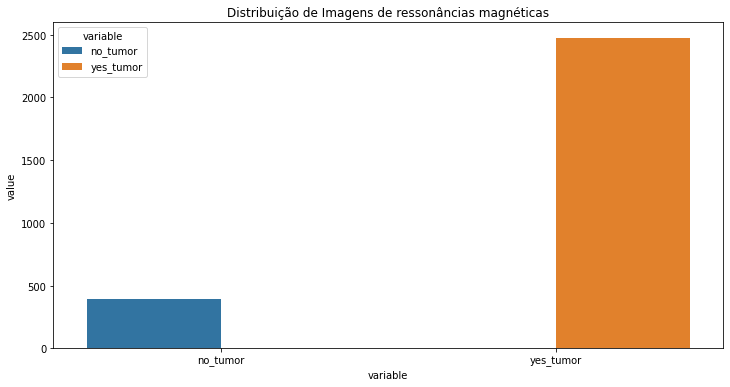

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset)])\
            .melt(), x = "variable", y="value", hue="variable")\
            .set_title('Distribuição de Imagens de ressonâncias magnéticas')

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

## Arquitetura da Rede Neural Convolucional (CNN)

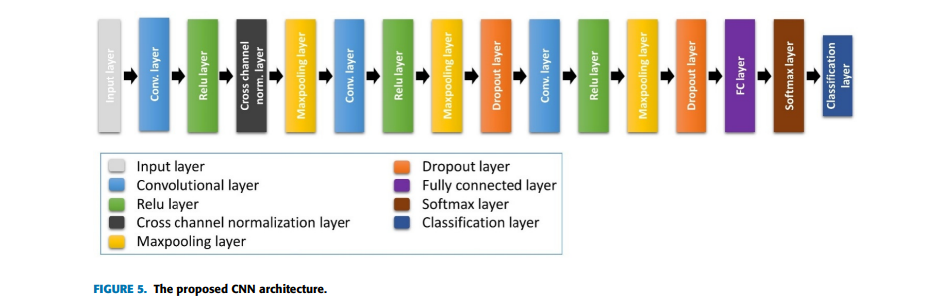

In [14]:
#Exemplo de arquitetura CNN
url = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Images/multi-classification architecture CNN.png'
img = io.imread(url)
cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

De acordo com a imagem acima, podemos visualizar a arquitetura promovida pela equipe do artigo, no qual apresenta três camadas de convolução, seguidas por funções de ativação ReLU, normalização em lote, pooling e dropout. Diante disso, a camadas convolucionais presentes em nossa modelagem terão 128 mapas de características (out_channels = 128), diferente do artigo que apresenta 64, porémm usufruiremos das mesmas composições de stride, padding, pooling e dropout que o artigo propõe.

In [15]:
classificador = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0)),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=64),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.1, inplace=True),

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.2, inplace=True),
    
    nn.Flatten(),
    nn.Linear(in_features=16384, out_features=256), #in_features = 16384
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [16]:
criterion = nn.BCELoss()
optimizer = optim.SGD(classificador.parameters(),  lr=0.01)

## Seta o uso de uma GPU responsável 

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [18]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=True)
  (8): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=True)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=16384, out_features=256, bias=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=1, bias=True)
  (18): Sigmoid()
)

## Modelo de treinamendo da Rede Neural 

In [19]:
loss_values = []
accu_values = []
def training_binary_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy


        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))
    loss_values.append(running_loss / len(loader))
    accu_values.append(running_accuracy/len(loader))

## Treinamento do modelo 

In [20]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

## Passagem dos dados de treino

In [21]:
for epoch in range(40):
    print("Treinando...")
    training_binary_loop(train_loader, epoch)
    classificador.eval()
    classificador.train()

Treinando...
Época   1 Finalizada: perda 0.42928 - precisão 0.86237
Treinando...
Época   2 Finalizada: perda 0.27823 - precisão 0.88074
Treinando...
Época   3 Finalizada: perda 0.21586 - precisão 0.91376
Treinando...
Época   4 Finalizada: perda 0.18748 - precisão 0.92121
Treinando...
Época   5 Finalizada: perda 0.16226 - precisão 0.93387
Treinando...
Época   6 Finalizada: perda 0.15868 - precisão 0.93264
Treinando...
Época   7 Finalizada: perda 0.13875 - precisão 0.94063
Treinando...
Época   8 Finalizada: perda 0.13232 - precisão 0.94201
Treinando...
Época   9 Finalizada: perda 0.11656 - precisão 0.94984
Treinando...
Época  10 Finalizada: perda 0.11172 - precisão 0.95417
Treinando...
Época  11 Finalizada: perda 0.10176 - precisão 0.96061
Treinando...
Época  12 Finalizada: perda 0.09875 - precisão 0.95505
Treinando...
Época  13 Finalizada: perda 0.08565 - precisão 0.96304
Treinando...
Época  14 Finalizada: perda 0.08612 - precisão 0.96215
Treinando...
Época  15 Finalizada: perda 0.08240

In [22]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values] 

## Passagem dos dados de teste

In [23]:
accu_values.clear()
loss_values.clear()
for epoch in range(40):
    classificador.eval()
    print("Validando...")
    training_binary_loop(test_loader, epoch)
    classificador.train()

Validando...
Época   1 Finalizada: perda 0.82077 - precisão 0.79231
Validando...
Época   2 Finalizada: perda 0.23541 - precisão 0.88654
Validando...
Época   3 Finalizada: perda 0.48018 - precisão 0.80913
Validando...
Época   4 Finalizada: perda 0.34714 - precisão 0.83462
Validando...
Época   5 Finalizada: perda 0.28092 - precisão 0.90865
Validando...
Época   6 Finalizada: perda 0.15175 - precisão 0.94471
Validando...
Época   7 Finalizada: perda 0.14991 - precisão 0.93413
Validando...
Época   8 Finalizada: perda 0.20535 - precisão 0.91106
Validando...
Época   9 Finalizada: perda 0.10229 - precisão 0.96635
Validando...
Época  10 Finalizada: perda 0.07358 - precisão 0.98077
Validando...
Época  11 Finalizada: perda 0.05957 - precisão 0.98798
Validando...
Época  12 Finalizada: perda 0.05391 - precisão 0.98558
Validando...
Época  13 Finalizada: perda 0.03403 - precisão 0.99038
Validando...
Época  14 Finalizada: perda 0.03008 - precisão 0.99279
Validando...
Época  15 Finalizada: perda 0.01950

In [24]:
loss_test = [item for item in loss_values]
accu_test = [item for item in accu_values]

## Análise de desempenho da CNN

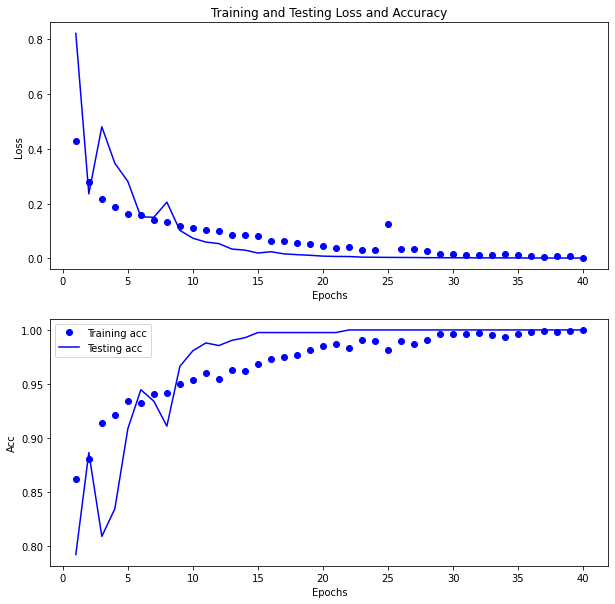

In [25]:
epochs_x = range(1, len(loss_test) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_train, 'bo', label='Training loss')
plt.plot(epochs_x, loss_test, 'b', label='Testing loss')
plt.title('Training and Testing Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
#val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, accu_train, 'bo', label='Training acc')
plt.plot(epochs_x, accu_test, 'b', label='Testing acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

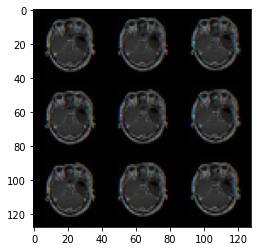

In [26]:
imagem1 = next(iter(train_loader))[0][1].view(128, 128, 3)
plt.imshow(imagem1)

In [27]:
imagem = imagem1.view(1, 3, 128, 128)
imagem = imagem.to(device)

In [28]:
previsao = classificador.forward(imagem)

previsao = F.softmax(previsao, dim=1)
print(previsao)
print()
previsao = previsao.cpu().detach().numpy()
print(previsao)

tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

[[1.]]


In [29]:
resultado = np.argmax(previsao)
print("Classe que a imagem pertence: {}".format(resultado))

Classe que a imagem pertence: 0


In [30]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = classificador(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[105.,   0.,   0.,   0.],
        [289.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])


Text(0.5, 69.0, 'Test label')

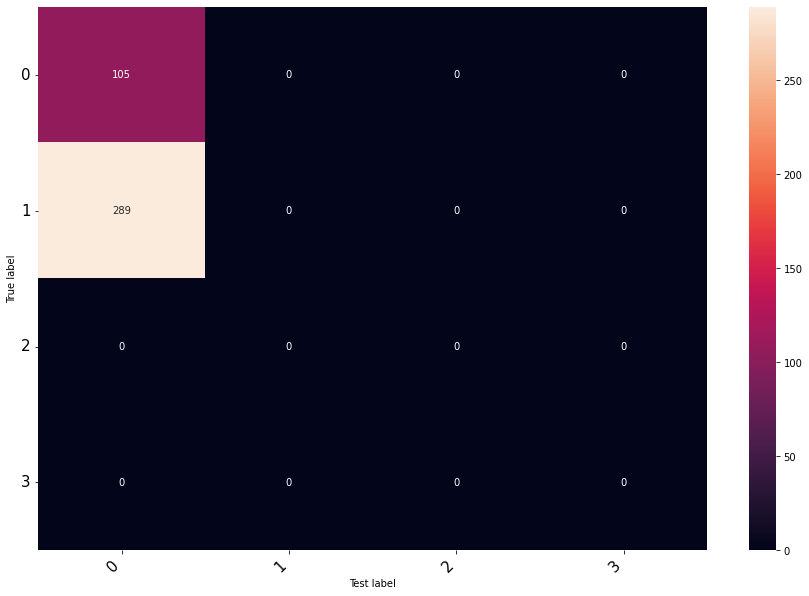

In [31]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(pd.DataFrame(confusion_matrix).astype(int), annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Test label')

In [32]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([1., 0., nan, nan])
